
  
# Attrition Part 2 
# EDA, Statistical Analysis, Modeling and Visualization with R
   <font size="3">Author: Amogh Rao</font>


## Contents

 1. Introduction and Ingestion
 2. Exploratory Data Analysis
 3. Socially Responsible People Analytics
 4. Pair Plots and Correlations
 5. Feature Importance and Selection
 6. Predicting Attrition
 7. Concluding Thoughts

## Introduction and Ingestion

In the second part of this project, I'll be exploring our prepared database in an effort to better understand what are the statistically significant drivers of attrition and how do we predict them, along with the model design we would implement in our solution and present as a dynamic dashboard.

In Part 1 we ingested, modeled and loaded the client data into our Postgres server. Now we will query this database and transform the data so its ready for analysis. Given how small this dataset is and the purpose of the analysis, I will be querying all the tables together. This will help give us an accurate idea of which variables are significantly correlated across dimension tables. In reality, we would probably want to join 2 to 3 tables at a time so our workspace isnt overwhelmed. We could decide this based on the business questions, or subject matter expertise. For example, compensation is usually correlated with experience, role and qualifications. So when analyzing compensation metrics, we would want to query all 3 dimension tables to look for sneaky multicollinearity that may come up later in our inferential modelling.

As a quick reminder, these are the business questions we want to address -

1. What kinds of attrition are we facing and how concerning are they given industry benchmarks?
2. Which departments and job roles are most at-risk?
3. What are the statistically significant drivers of attrition based on our pre-defined metrics?
4. What is every employee's risk of exit (Probability of Attrition)?

For this project we'll be focusing on 2 types of attrition -

1. New Hire Attrition
2. Regrettable/High-Performer Attrition

### Loading The Necessary Libraries

In [229]:
options(warn=-1)
library(tidyverse)
library(data.table)
library(RPostgres)
library(DBI)
library(GGally)
library(plotly)
library(corrplot)
library(ggcorrplot)
library(heatmaply)
library(gridExtra)
library(fastDummies)
library(wesanderson)
library(repr)
library(caTools)
library(MASS)
library(DescTools)
library(car)
library(caret)
library(ROCR)

### Connect to Database

In [3]:
con <- dbConnect(RPostgres::Postgres(), 
                 dbname = "ibmattrition", 
                 host = "localhost", 
                 port = 5432,
                 user = "postgres",
                 password = "petproject")

### Build Analysis Dataset

In [245]:
alltables  <- dbSendQuery(con, "SELECT * FROM churn.orgid
JOIN churn.compensation USING (employeeid)
JOIN churn.function USING (employeeid)
JOIN churn.engagement USING (employeeid)
JOIN churn.performance USING (employeeid)
JOIN churn.personal USING (employeeid)")

df <- dbFetch(alltables)

### Quick Data Cleaning and Prep

In [246]:
df  <- df %>% mutate_if(is.character, as.factor) # We're gonna turn all the character variables into factors
df <- subset(df, select = -c(employeeid)) # Since employeeid isn't a predictor, we'll be excluding it from the analysis

In [119]:
str(df)

'data.frame':	1470 obs. of  28 variables:
 $ attrition        : Factor w/ 2 levels "No","Yes": 2 1 2 1 1 1 1 1 1 1 ...
 $ dailyrate        : num  1102 279 1373 1392 591 ...
 $ income           : num  5993 5130 2090 2909 3468 ...
 $ overtime         : Factor w/ 2 levels "No","Yes": 2 1 2 2 1 1 2 1 1 1 ...
 $ salaryhike       : num  11 23 15 11 12 13 20 22 21 13 ...
 $ stockoption      : int  0 1 0 0 1 0 3 1 0 2 ...
 $ department       : Factor w/ 3 levels "Human Resources",..: 3 2 2 2 2 2 2 2 2 2 ...
 $ jobrole          : Factor w/ 9 levels "Healthcare Representative",..: 8 7 3 7 3 3 3 3 5 1 ...
 $ joblevel         : int  2 2 1 1 1 1 1 1 3 2 ...
 $ travel           : Factor w/ 3 levels "Non-Travel","Travel_Frequently",..: 3 2 3 2 3 2 3 3 2 3 ...
 $ envsat           : int  2 3 4 4 1 4 3 4 4 3 ...
 $ involvement      : int  3 2 2 3 3 3 4 3 2 3 ...
 $ jobsat           : int  4 2 3 3 2 4 1 3 3 3 ...
 $ relationsat      : int  1 4 2 3 4 3 1 2 2 2 ...
 $ yearswithmanager : int  5 7 0 0 2 6 0 

## Exploratory Analysis

For the introductory EDA, I'll be following a question-answer pattern where I can put my thoughts down and dig into the drivers of those thoughts.

1. Types of attrition
2. General breakdown of attrition by features
3. Statistical significance of drivers

### What's the total attrition count and percentage?

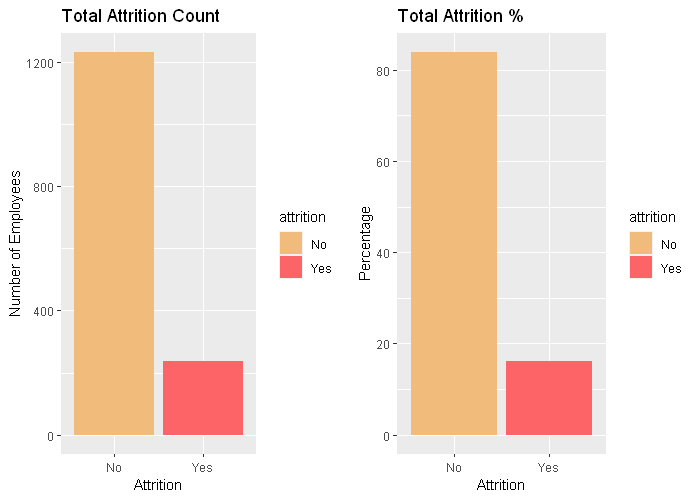

In [257]:
options(repr.plot.width=7, repr.plot.height=5)

count <- ggplot(aes(x=attrition, fill = attrition), data = df) + geom_bar() + ggtitle("Total Attrition Count") +
xlab("Attrition") + ylab("Number of Employees") + scale_fill_manual(values = wes_palette(2, name = "GrandBudapest1"))

percent <- ggplot(aes(x=attrition, fill = attrition), data = df) + ggtitle("Total Attrition %") +
geom_bar(aes(y = (..count..)*100/sum(..count..))) + xlab("Attrition") + ylab("Percentage") + 
scale_fill_manual(values = wes_palette(2, name = "GrandBudapest1"))

grid.arrange(count, percent, ncol=2)

### Does this attrition look different for new hires and high performers?

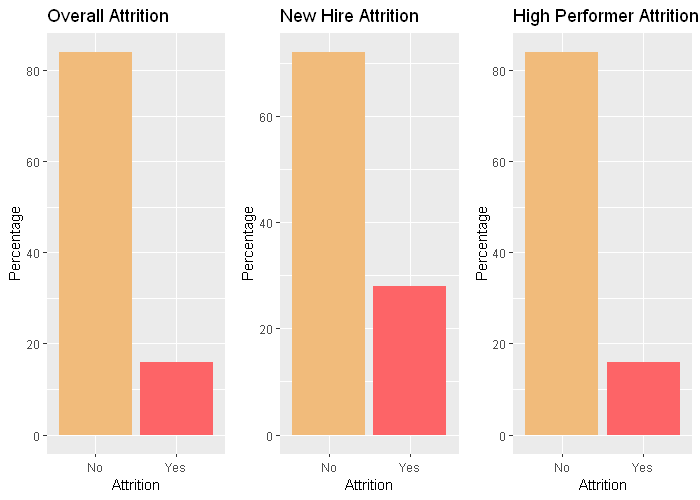

In [255]:
# Suppress summarise info
options(dplyr.summarise.inform = FALSE)

df$newhire <- ifelse(df$currentrole <= 1, "Yes", "No")
dfn <- df[df$newhire == "Yes",]

df$highperformer <- ifelse(df$performancerating == 4 , "Yes", "No")
dfhp <- df[df$highperformer == "Yes",]

overall  <- df %>% group_by(attrition) %>% summarise(Count=n()) %>% 
mutate(percent=round(prop.table(Count),2) * 100) %>% ggplot(aes(x=attrition, y=percent, fill = attrition)) + 
geom_bar(stat="identity", show.legend = FALSE) + labs(x="Attrition", y="Percentage") + 
ggtitle("Overall Attrition") +
scale_fill_manual(values = wes_palette(2, name = "GrandBudapest1")) 

nh  <- dfn %>% group_by(attrition) %>% summarise(Count=n()) %>% 
mutate(percent=round(prop.table(Count),2) * 100) %>% ggplot(aes(x=attrition, y=percent, fill = attrition)) + 
geom_bar(stat="identity", show.legend = FALSE) + labs(x="Attrition", y="Percentage") +
ggtitle("New Hire Attrition") +
scale_fill_manual(values = wes_palette(2, name = "GrandBudapest1"))

hp  <- dfhp %>% group_by(attrition) %>% summarise(Count=n()) %>% 
mutate(percent=round(prop.table(Count),2) * 100) %>% ggplot(aes(x=attrition, y=percent, fill = attrition)) + 
geom_bar(stat="identity", show.legend = FALSE) + labs(x="Attrition", y="Percentage") + 
ggtitle("High Performer Attrition") +
scale_fill_manual(values = wes_palette(2, name = "GrandBudapest1"))


grid.arrange(overall, nh, hp, ncol=3)

A major concern here is that new hire attrition is far above the regular rate, not to mention far above the <a href="https://www.linkedin.com/business/learning/blog/learner-engagement/see-the-industries-with-the-highest-turnover-and-why-it-s-so-hi" target="_blank">industry benchmark of 13.2% attrition</a>. Fortunately, our high performer attrition is not worrying.

### Let's explore this attrition by some common facets - Gender, Department and Job Role

When working with a data sample, faceting by percentages can quickly lead to dangerous conclusions that are not justified, simply because we don't see the absolute sample values and their distribution across the facets. Keeping this in mind, I'm gonna go with the unpopular opinion that count is a better tool for visualization than percentage, particularly in situations where samples are small.

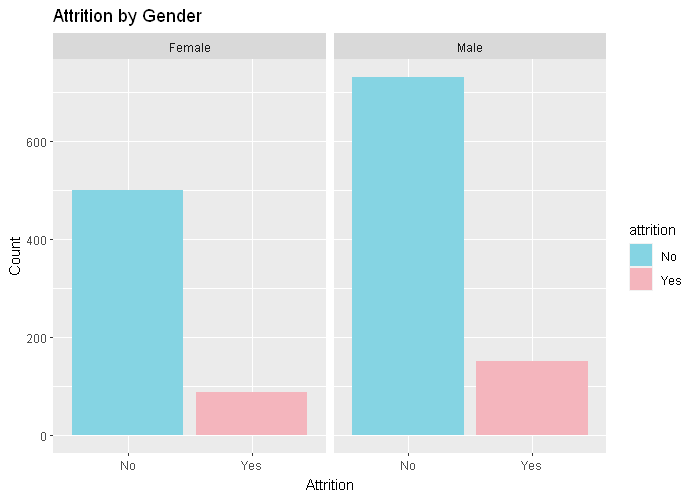

In [258]:
ggplot(aes(x=attrition, fill = attrition), data = df) + geom_bar() + 
scale_fill_manual(values = wes_palette(2, name = "Moonrise3")) + facet_wrap(~gender) + 
ggtitle("Attrition by Gender") +xlab("Attrition") + ylab("Count")

There doesn't seem to be any particularly concerning gender bias in attrition, but we might want to revisit this parameter while controling for other factors that influence the demographics. 

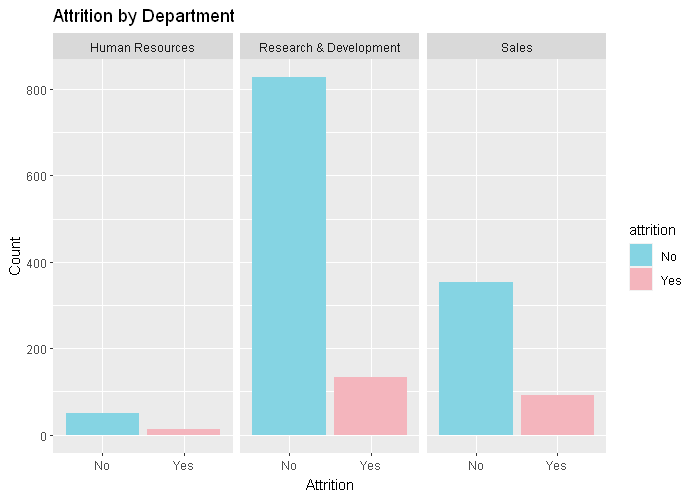

In [259]:
ggplot(aes(x=attrition, fill = attrition), data = df) + geom_bar()+ 
scale_fill_manual(values = wes_palette(2, name = "Moonrise3")) + facet_wrap(~department) + 
ggtitle("Attrition by Department") +xlab("Attrition") + ylab("Count")

Unsurprisingly, sales is our leading source of attrition by proportion, but overall doesn't seem to be at worryingly high absolute values. A time series plot would be wonderful right about now, but sadly we have to work with static data.

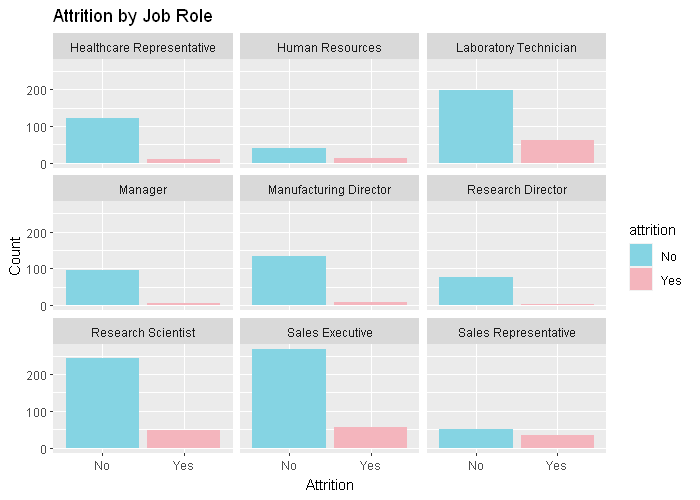

In [261]:
ggplot(aes(x=attrition, fill = attrition), data = df) + geom_bar()+ 
scale_fill_manual(values = wes_palette(2, name = "Moonrise3")) + facet_wrap(~jobrole) + 
ggtitle("Attrition by Job Role") + xlab("Attrition") + ylab("Count")

Sales reps seem to have an incredibly high attrition rate, but I'm willing to bet that our tiny sample size is skewing these observations. Yet its good to know which roles to keep an eye on.

### Finally, lets look at some important distributions - Age, Monthly Income and Experience

Our histogram her shows the overall distribution of each variable, while the density plot in pink shows us the attrition distribution of those who have already left the company.

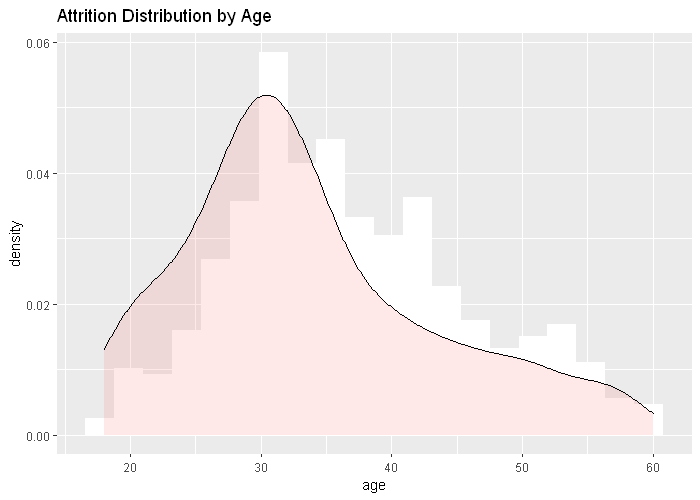

In [262]:
adf <- df[df$attrition == 'Yes',]

ggplot(df, aes(x=age)) + 
 geom_histogram(aes(y=..density..), fill="white", bins = 20)+
 geom_density(data = adf, aes(x = age), alpha=.15, fill="#FF6666") + ggtitle("Attrition Distribution by Age")

Looking at the difference in density and bin heights under 30 years, we can see that a disproportionately higher number of younger employees seem to be leaving the company.

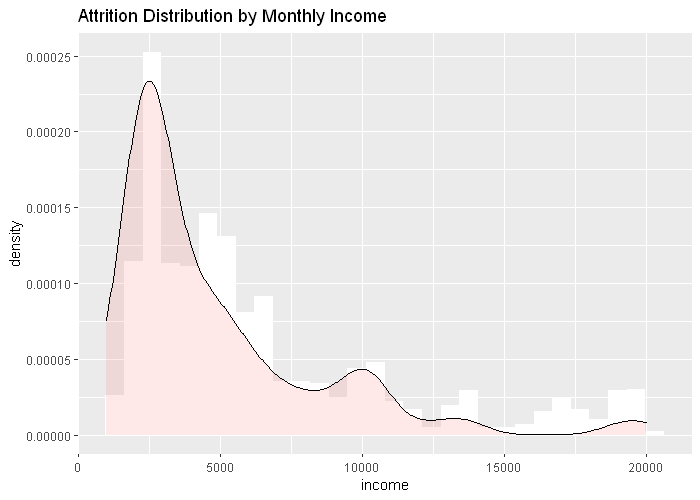

In [263]:
ggplot(df, aes(x=income)) + 
geom_histogram(aes(y=..density..), fill="white", bins = 30)+
geom_density(data = adf, aes(x = income), alpha=.15, fill="#FF6666") + 
ggtitle("Attrition Distribution by Monthly Income")

There doesn't seem to be any discernable concern with respect to employee income, but given how crucial this factor is we would want to validate our hypothesis in our regression.

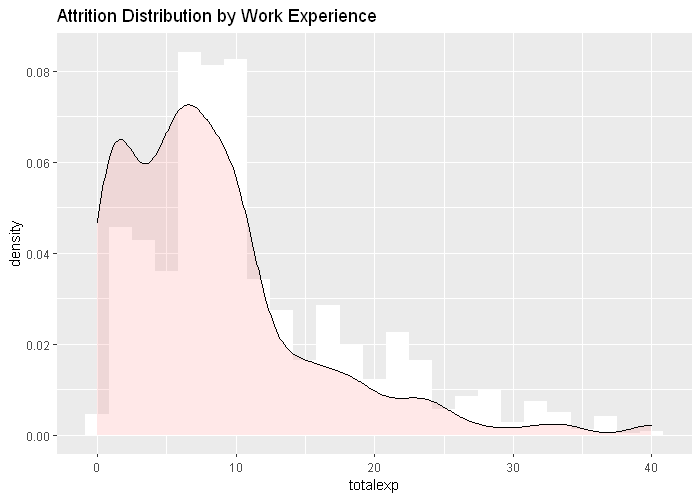

In [264]:
ggplot(df, aes(x=totalexp)) + 
geom_histogram(aes(y=..density..), fill="white", bins = 25)+
geom_density(data = adf, aes(x = totalexp), alpha=.15, fill="#FF6666") + 
ggtitle("Attrition Distribution by Work Experience")

Looks like less experienced employees (under 6 years) seem to have a higher rate of attrition than the veterans. This combined with our insights about age, paints a worrying picture about the younger workforce contributing to more than their fair share of churn. We can keep these in mind when looking at our attrition drivers.

## Socially Responsible People Analytics

Some important considerations that we tend to miss while working with people data are the ethical and moral implication of our analysis. A lot of algorithms and models have inherent biases due to biased data. It's our job to build a responsible model and feed it the right ingredients keeping in mind social and cultural contexts. Given that, I'll be excluding gender and marital status from this analysis since we'll be using this dataset to build a predictive model. However, once our model has been built we can always look for associations with these variables. For example, if our model predicts a disproportionately high probability of attrition for women, we would want to look into the underlying drivers.

In [185]:
df <- subset(df, select = -c(gender, maritalstatus))

## Pair Plots and Correlations

Before jumping into modeling, we're gonna want to look at relationships between potential variables we would have to consider in our feature selection. There's all kinds of different ways to do this, but I'm gonna begin by building a bloated model with every single feature. Then, using stepwise regression based on AIC values, I'll cut down the irrelevant features. Finally, using pair plots and correlations with dummy coded variables, I'll decide which features should be removed or changed to fit our use case.

In [222]:
# Bloated Model

set.seed(2017)
sampletrain <- sample(1:nrow(df), nrow(df)*.7)
sampletest = -sampletrain

train <- df[sampletrain,]
test <- df[sampletest,]

logdf <- train
logdf$attrition  <- ifelse(logdf$attrition == 'Yes', 1, 0)
logdf$attrition  <- as.numeric(logdf$attrition)
chonk  <- glm(attrition ~ ., data = logdf, family="binomial")

In [223]:
summary(chonk)


Call:
glm(formula = attrition ~ ., family = "binomial", data = logdf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7738  -0.4860  -0.2501  -0.0914   3.2983  

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -9.421e+00  4.646e+02  -0.020 0.983823    
dailyrate                        -3.786e-04  2.623e-04  -1.443 0.148904    
income                            1.123e-05  9.879e-05   0.114 0.909457    
overtimeYes                       1.863e+00  2.306e-01   8.080 6.49e-16 ***
salaryhike                       -3.174e-02  4.648e-02  -0.683 0.494698    
stockoption                      -5.238e-01  1.388e-01  -3.774 0.000161 ***
departmentResearch & Development  1.223e+01  4.646e+02   0.026 0.979008    
departmentSales                   1.091e+01  4.646e+02   0.023 0.981274    
jobroleHuman Resources            1.341e+01  4.646e+02   0.029 0.976972    
jobroleLaboratory Technician      1.308e

Right off the bat we have some super interesting insights. Our strongest predictor here by a large margin (going by t stat value and significance) is whether or not the employee is working overtime. The other predictors are our usual culprits, such as engagement, history of job change, distance from home, frequency of travel and years since last promotion.

We also have some surprising insights, like salary hike, income, education and performance not being statistically significant in predicting probability of attrition.

Let's remove some clearly redundant features and dig a little deeper.

In [265]:
logdf <- subset(logdf, select = -c(department, performancerating, education, educationfield))

Now we dummy code our variables since we can't run a Pearson correlation with all these categorical variables.

In [271]:
dummydf <- dummy_cols(logdf)
dummydf  <- subset(dummydf, select = -c(overtime, jobrole, travel))

head(cor(dummydf))

,attrition,dailyrate,income,salaryhike,stockoption,joblevel,envsat,involvement,jobsat,relationsat,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,travel_Non-Travel,travel_Travel_Frequently,travel_Travel_Rarely
attrition,1.000000000,-0.0619691960,-0.1564768453,-0.003537697,-0.10847465,-0.162733257,-0.118304856,-0.125012811,-0.12223932,-0.04980603,...,0.06437255,-0.083471420,-0.091127018,-0.083394191,0.022074589,0.028738863,0.152251111,-0.076612997,0.134926816,-0.063620608
dailyrate,-0.061969196,1.0000000000,-0.0005192943,0.038544907,0.04299799,-0.004461402,-0.028578654,0.019215171,0.01269684,0.01448048,...,-0.01291719,-0.016617299,0.001091403,0.005801604,0.010647116,-0.001688930,-0.004228182,0.003207718,-0.032483465,0.025568433
income,-0.156476845,-0.0005192943,1.0000000000,-0.041911813,-0.03235966,0.952741330,0.004656956,0.001157358,-0.02820851,0.04125123,...,-0.32421604,0.631432527,0.046877775,0.477073576,-0.341623356,0.030835979,-0.210838826,-0.014492961,-0.030949276,0.036168565
salaryhike,-0.003537697,0.0385449069,-0.0419118127,1.000000000,0.02298673,-0.050273389,-0.049287059,0.010718617,0.02275090,-0.08605090,...,-0.02146378,-0.006922995,0.016670026,-0.033135856,0.058343672,-0.047446659,0.018056553,0.041405051,-0.006557992,-0.022261158
stockoption,-0.108474652,0.0429979852,-0.0323596627,0.022986732,1.00000000,-0.036118510,0.023578432,0.021627761,0.01891831,-0.07442644,...,0.05718961,-0.034867381,-0.026358583,0.004642211,-0.002857759,-0.007645196,-0.036756909,0.035882658,-0.020217931,-0.006885866
joblevel,-0.162733257,-0.0044614021,0.9527413300,-0.050273389,-0.03611851,1.000000000,0.013527172,0.008042777,-0.01526789,0.04017276,...,-0.34820622,0.565759564,0.109210901,0.407851562,-0.391011442,0.112283687,-0.228175301,-0.009125455,-0.024040533,0.026660061


I'm not sure if there's an industry standard or rule of thumb for feature elimination based on correlation, so I'm gonna make the assumption than anything over 60% is concerning. Let's rerun the code with our threshold. 

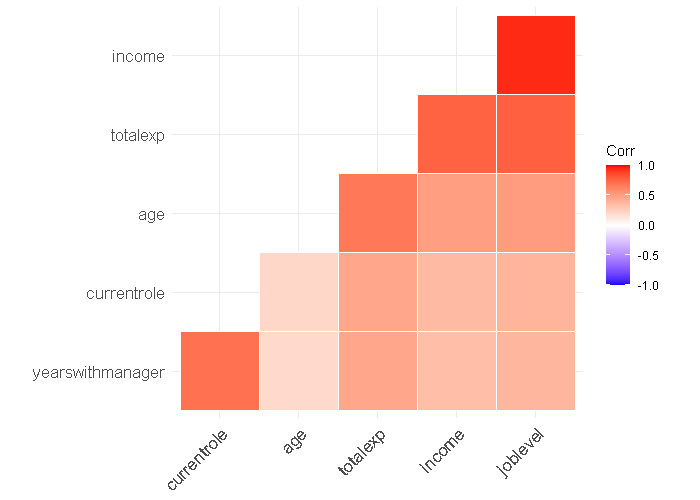

In [273]:
imp <- subset(df, select = c(totalexp, age, yearswithmanager, income, currentrole, joblevel))

corr.plot <- ggcorrplot(cor(imp), hc.order = TRUE, type = "lower", outline.col = "white")
corr.plot

None of these correlations seem surprising. However, we're going to have to decide how to deal with them. The good news is that based on our feature significance, we can drop job level, years with manager and income. This makes life much easier since our remaining features aren't significantly correlated with each other. 

In [189]:
logdf  <- subset(logdf, select = -c(income, joblevel, yearswithmanager))

In [200]:
smallchonk  <- glm(attrition ~ ., data = logdf, family="binomial"(link = "logit"))

As a final step, we're gonna check the variance inflation factors for our remaining features just to make sure we don't have any trouble down the line.

In [202]:
vif <- car::vif(smallchonk)
print(vif)

                      GVIF Df GVIF^(1/(2*Df))
dailyrate         1.034547  1        1.017127
overtime          1.185942  1        1.089010
salaryhike        1.043341  1        1.021440
stockoption       1.056612  1        1.027917
jobrole           1.886120  8        1.040454
travel            1.155135  2        1.036712
envsat            1.096223  1        1.047007
involvement       1.057007  1        1.028108
jobsat            1.038439  1        1.019038
relationsat       1.079122  1        1.038808
worklifebal       1.052796  1        1.026059
lastpromotion     1.732871  1        1.316385
currentrole       1.653487  1        1.285880
trainings         1.047155  1        1.023306
age               1.853968  1        1.361605
distfromhome      1.058743  1        1.028952
previouscompanies 1.336964  1        1.156271
totalexp          2.799192  1        1.673079


As expected, nothing too concerning here.

We're now gonna do stepwise model selection using AIC as our elimination criteria. We'll begin this with a function, but gradually use our own discretion given external context.

In [204]:
stepAIC(smallchonk, trace = F)


Call:  glm(formula = attrition ~ overtime + stockoption + jobrole + 
    travel + envsat + involvement + jobsat + relationsat + worklifebal + 
    lastpromotion + currentrole + trainings + age + distfromhome + 
    previouscompanies + totalexp, family = binomial(link = "logit"), 
    data = logdf)

Coefficients:
                  (Intercept)                    overtimeYes  
                      2.26387                        1.87354  
                  stockoption         jobroleHuman Resources  
                     -0.47684                        1.95712  
 jobroleLaboratory Technician                 jobroleManager  
                      1.86602                        0.67313  
jobroleManufacturing Director       jobroleResearch Director  
                      1.02529                       -1.33343  
    jobroleResearch Scientist         jobroleSales Executive  
                      1.19620                        1.45930  
  jobroleSales Representative        travelTravel_Frequ

In [207]:
model  <- glm(formula = attrition ~ overtime + stockoption + jobrole + travel + envsat + involvement + 
jobsat + relationsat + worklifebal + lastpromotion + currentrole + trainings + age + distfromhome + 
previouscompanies + totalexp , data = logdf, family = binomial(link = "logit"))

In [208]:
summary(model)


Call:
glm(formula = attrition ~ overtime + stockoption + jobrole + 
    travel + envsat + involvement + jobsat + relationsat + worklifebal + 
    lastpromotion + currentrole + trainings + age + distfromhome + 
    previouscompanies + totalexp, family = binomial(link = "logit"), 
    data = logdf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5971  -0.5166  -0.2705  -0.1022   3.6309  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    2.26387    1.07451   2.107 0.035127 *  
overtimeYes                    1.87354    0.22651   8.271  < 2e-16 ***
stockoption                   -0.47684    0.13485  -3.536 0.000406 ***
jobroleHuman Resources         1.95712    0.69282   2.825 0.004730 ** 
jobroleLaboratory Technician   1.86602    0.56446   3.306 0.000947 ***
jobroleManager                 0.67313    0.82926   0.812 0.416949    
jobroleManufacturing Director  1.02529    0.64861   1.581 0.113931    
jobr

Now that we've begun working with "serious" features, it's only fair that we become more critical of our model's capabilities. If this were a linear model we could just pull the R-squared and call it a day. But since the stats community has never reached an agreement on the best pseudo Rsq for a GLM, let's just call it Christmas and use them all.

In [196]:
DescTools::PseudoR2(stepmodel, which = c("McFadden", "CoxSnell", "Nagelkerke", "Tjur"))

McFadden   CoxSnell Nagelkerke       Tjur 
 0.3190543  0.2456897  0.4187276  0.3447173

Now we know that Cox and Snell is notoriously critical, so we're gonna keep that in mind here. Given that we're working with people data and that in my humble opinion human beings are the most complex and dynamic systems on the planet, I think a model that explains 30-40% of the overall variance is a great start.

That is to say, I would never deploy this model to find out who's gonna quit and decide where to allocate my hiring budget for the next financial year, but this is a good start to better understand the drivers of attrition (as was our original goal).

## Predicting Attrition

Now for the fun stuff. We're gonna use our model above to predict attrition, find out our model's accuracy and look at the trade-offs between sensitivity and specificity in the context of our business case.

In [226]:
test$attrition  <- ifelse(test$attrition == 'Yes', 1, 0)
predictions <- predict(model, newdata=test, type='response')
test$predictions <- ifelse(predictions >= 0.5, 1, 0)
test$predictions <- as.factor(test$predictions)
test$attrition  <- as.factor(test$attrition)

caret::confusionMatrix(test$predictions, test$attrition)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 358  40
         1  10  33
                                          
               Accuracy : 0.8866          
                 95% CI : (0.8533, 0.9147)
    No Information Rate : 0.8345          
    P-Value [Acc > NIR] : 0.001323        
                                          
                  Kappa : 0.5087          
                                          
 Mcnemar's Test P-Value : 4.11e-05        
                                          
            Sensitivity : 0.9728          
            Specificity : 0.4521          
         Pos Pred Value : 0.8995          
         Neg Pred Value : 0.7674          
             Prevalence : 0.8345          
         Detection Rate : 0.8118          
   Detection Prevalence : 0.9025          
      Balanced Accuracy : 0.7124          
                                          
       'Positive' Class : 0               
                              

We've got a model accuracy of 88%! Can't get swayed by this though, cause our sample sizes are way too small to take this accuracy to heart. Especially when working with people data. However, this is still a great indicator that we have a functioning model that can help us tackle future attrition.

Our sensitivity is incredibly high, but our specificity is a bit poor. Putting this into business context, we will almost certainly correctly identify an employee that plans to quit. On the other hand, we will more often than not be unable to correctly identify people who plan to stay. This is exactly what we want, since even though we would want to use our engagement and L&D budget wisely, our priority is to minimize attrition and its associated hiring, onboarding and training costs, and long term impact on culture and organizational health. 

Let's look at an ROC curve to see how to adjust our probability threshold.

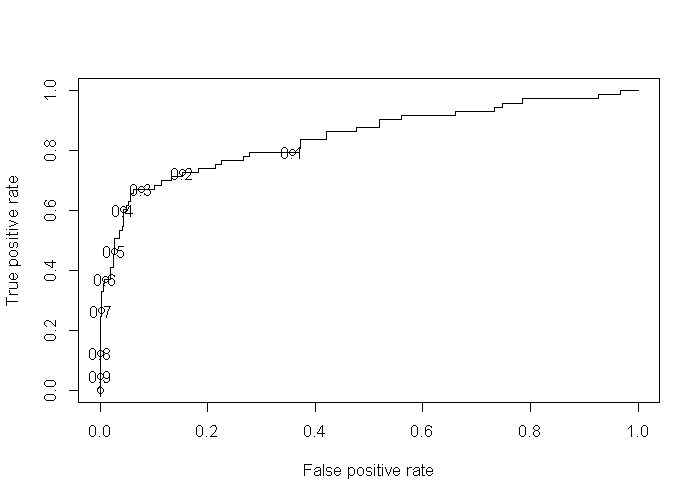

In [274]:
rocprediction <- prediction(predictions, test$attrition)
rocperformance <- performance(rocprediction,"tpr","fpr")
plot(rocperformance, print.cutoffs.at = seq(0.1, by = 0.1))

Looks like a threshold of 0.35 or so would do us more justice. Let's validate that.

In [237]:
test$predictions <- ifelse(predictions >= 0.35, 1, 0)
test$predictions <- as.factor(test$predictions)
test$attrition  <- as.factor(test$attrition)

caret::confusionMatrix(test$predictions, test$attrition)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 348  27
         1  20  46
                                          
               Accuracy : 0.8934          
                 95% CI : (0.8608, 0.9206)
    No Information Rate : 0.8345          
    P-Value [Acc > NIR] : 0.0002971       
                                          
                  Kappa : 0.5988          
                                          
 Mcnemar's Test P-Value : 0.3814706       
                                          
            Sensitivity : 0.9457          
            Specificity : 0.6301          
         Pos Pred Value : 0.9280          
         Neg Pred Value : 0.6970          
             Prevalence : 0.8345          
         Detection Rate : 0.7891          
   Detection Prevalence : 0.8503          
      Balanced Accuracy : 0.7879          
                                          
       'Positive' Class : 0               
                              

Looks like we took a bit of a hit with our sensitivity, but our specificity has sky-rocketed. However, given our business case it might be best to stick with the default threshold. Again, we would want to validate these with all the client data and not just a sample of it.

Given that our client's focus is on new hire and high performer attrition, we would want to apply this model to datasets filtered for those considerations and tweak our parameters and thresholds accordingly.

## Concluding Thoughts

There seem to be some fairly strightforward insights into IBM's attrition dilemma. However, implementing any correctional measures would be far from simple. I personally believe that attrition modeling should not be done with static data. A time series analysis and more importantly, models derived from survival analytics (like Cox proportional hazards regression) are far better suited to notice higher level, big picture issues with organizational attrition as a whole. However, the insights we have received from this analysis would definitely help direct HR strategy, particularly from the perspective of employee engagement, work-life balance and inclusivity. 

We are now ready to embed this model into Tableau using the Rserve connection, and build our MVP.